This notebook will develop techniques for mapping LIBS spectra to line intensities
The observed Voigt peaks are the experimentally observed artifact of a line emission at precise energy
Almost all of the processing and fitting will be more direct with lines vs. peaks
Examples of pre-processing considered includes assessment of temperature based on relative line intensities (by el/ion state)
Moreover (at known temp) the line intensities are directly proportional to elemental/ionic concentration in the plasma

In [90]:
#reference paper is "continuous wavelet transform based automatic curve fitting method for LIBS, Yang 2018, Applied Optics"
#rather than start with wavelet transform, approach peak identification numerically
#If, at every point, we calculate the difference in intensity to adjacent points (before / after) we detect maxima
#In presence of noise more advanced technique needed, perhaps relative to average of min 2 of three point. (drop outlier)
#For simulated /smoothed spectra a simple approach should be sufficient

In [91]:
#imports and env
import numpy as np
import pickle
#import math
from scipy.special import voigt_profile as voigt
from scipy.optimize import least_squares
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.colors import n_colors

#needed to import our package from sibling directory
import os
import sys
sys.path.insert(0, os.path.abspath('../..'))
from libs_unet.training.spec_maker import spectrum_maker
from pathlib import Path

top_dir = Path.cwd() #working directory for notebook should be location of notebook
rel_path = 'data' 
datapath = top_dir / rel_path

In [92]:
#create LIBS spectrum with indicated elemental fractions
spec_maker = spectrum_maker()
fracs_dict = {'Li':0.33, 'C':0.17, 'O':0.5}
li2co3_wave, spec_dict, lines_dict = spec_maker.make_spectra(fracs_dict, comp_only=True)
li2co3_spec = spec_dict['comp']
li2co3_lines = lines_dict['comp']

In [93]:
li2co3_wave[np.argmax(li2co3_spec)]

670.7666666666388

<function matplotlib.pyplot.show(close=None, block=None)>

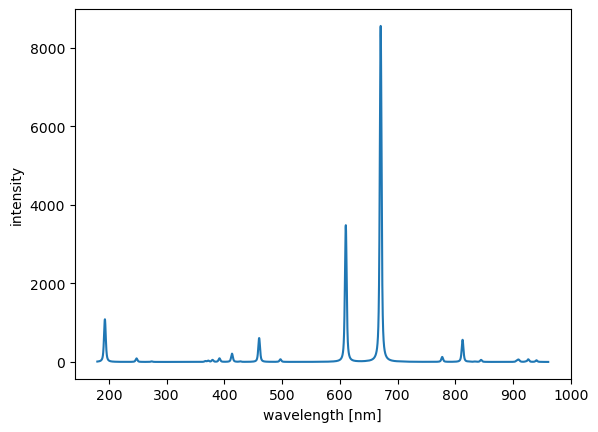

In [94]:
#Inspect LIBS spectrum
plt.plot(li2co3_wave, li2co3_spec) 
plt.xlabel('wavelength [nm]')   
plt.ylabel('intensity')
plt.show

In [95]:
#next let's try basic peak identification, skip first and last points
li2co3_peaks = np.zeros(len(li2co3_wave)).astype('int')
for wl in range(len(li2co3_wave)):
    if (wl ==0 or wl == len(li2co3_wave)-1):
        pass
    elif (li2co3_spec[wl] > li2co3_spec[wl - 1] and li2co3_spec[wl] > li2co3_spec[wl + 1]):
        li2co3_peaks[wl] = 1
    else:
        pass


In [96]:
#see how many peaks found
np.sum(li2co3_peaks)

25

<function matplotlib.pyplot.show(close=None, block=None)>

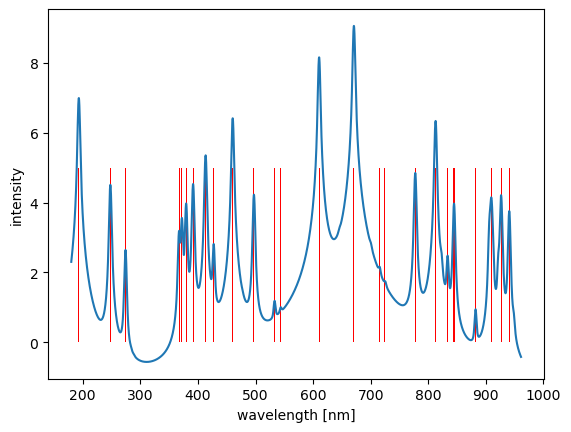

In [97]:
#plot peaks on spectrum, log int for vis, we see good unique peak detection
plt.plot(li2co3_wave, np.log(li2co3_spec+0.1)) 
plt.bar(x=li2co3_wave, height = 5*li2co3_peaks, width=2, color='red') #note width impacts line vis
plt.xlabel('wavelength [nm]')   
plt.ylabel('intensity')
plt.show

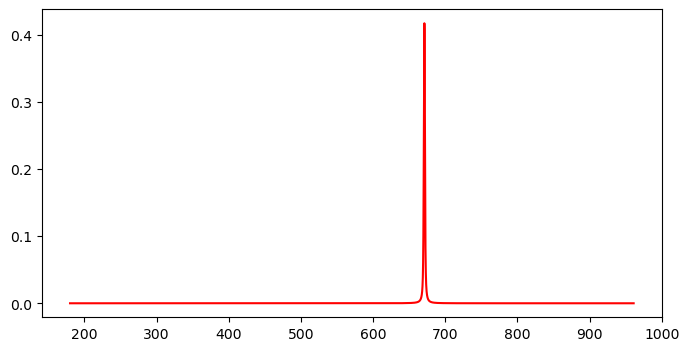

In [98]:
#first attempt a naive fit with voigt profiles at each peak location, solving for line intensities
#assert a fixed set of parameters based on the max intensity peak
fig, ax = plt.subplots(figsize=(8, 4))
peak_loc = 671
sigma = 0.5
gamma = 0.5
fit_profile = voigt(li2co3_wave-peak_loc, sigma, gamma)
ax.plot(li2co3_wave, fit_profile, color='red')

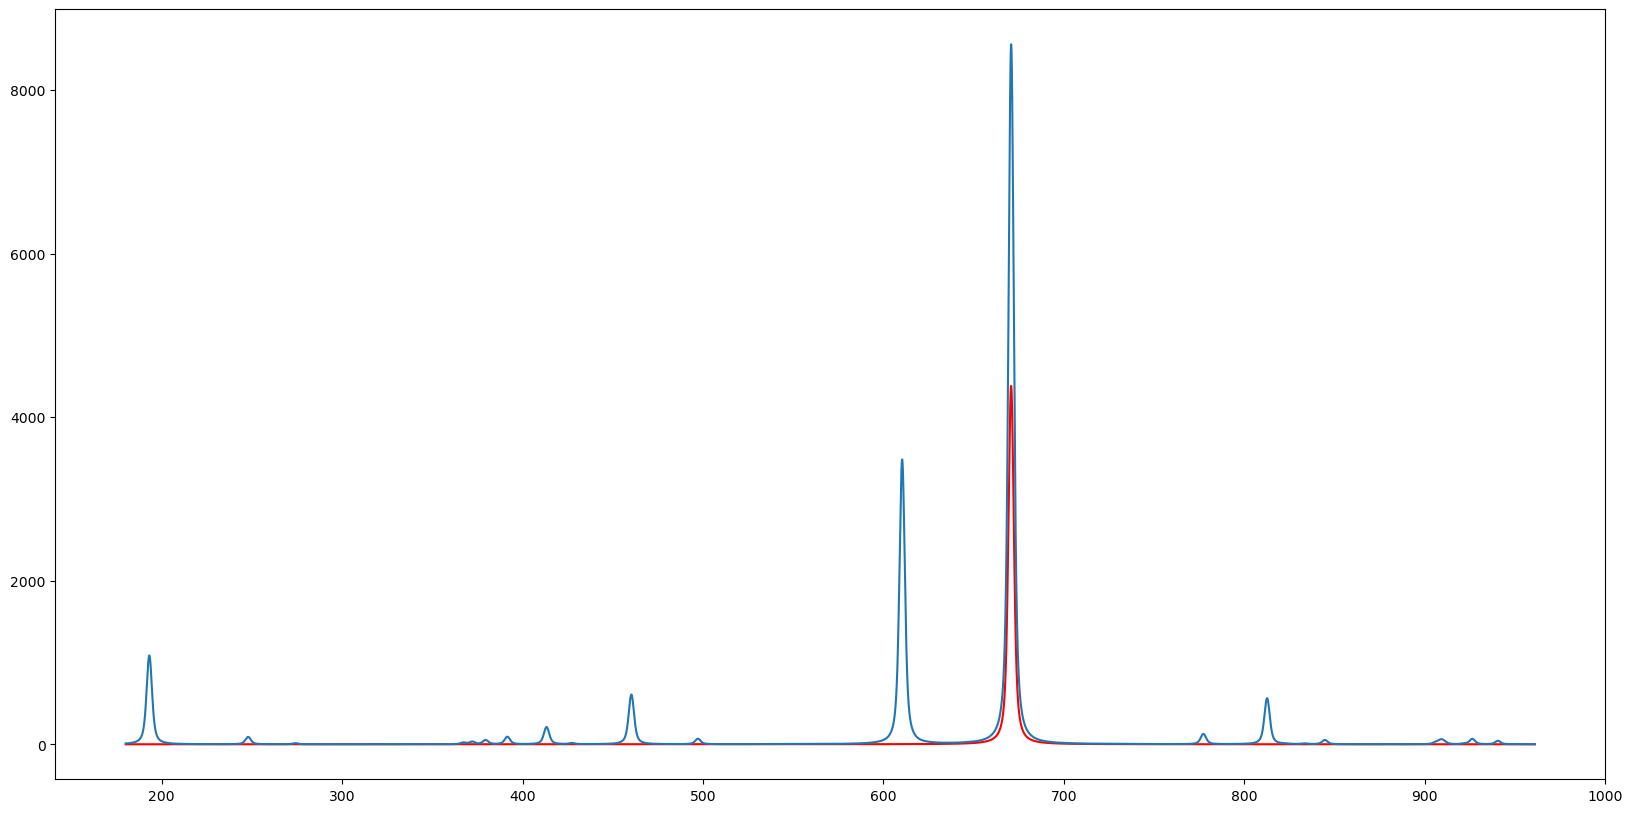

In [99]:
#now fit this over the spectrum, adjusting params to match shape/height
fig, ax = plt.subplots(figsize=(20, 10))
peak_loc = li2co3_wave[np.argmax(li2co3_spec)]
sigma = 1
gamma = 1
fit_scale = 2.1e4 #halve to actually see the red peak at 670.766
fit_profile = voigt(li2co3_wave-peak_loc, sigma, gamma)
plt_mask = li2co3_wave > 0
#plt_mask = np.all([wave >= 750, wave <= 770], axis=0)
ax.plot(li2co3_wave[plt_mask], fit_scale*fit_profile[plt_mask], color='red')
ax.plot(li2co3_wave[plt_mask], li2co3_spec[plt_mask])
#sigma and gamma =1 is basically perfect shape here. Params used to make spectra so makes sense
#TODO establish a fitting algorithm to fit these params

In [100]:
#we will use a least-squares approach to fit n=peaks voigt profiles
#independent variables are the n scale factors 
# scale equivalent to the atomic line intensities behind the spectrum

#first determine the wavelengths to center the profiles on
li2co3_peak_loc = []
li2co3_peak_height = []
for i in range(len(li2co3_wave)):
    if li2co3_peaks[i] == 1:
        li2co3_peak_loc.append(li2co3_wave[i])
        li2co3_peak_height.append(li2co3_spec[i])
li2co3_peak_loc = np.asarray(li2co3_peak_loc)
li2co3_peak_height = np.asarray(li2co3_peak_height)
li2co3_shifts = np.ones((len(li2co3_peak_loc), len(li2co3_wave)))
li2co3_shifts = li2co3_shifts * li2co3_wave
li2co3_shifts = li2co3_shifts - li2co3_peak_loc[:,None]
profiles = voigt(li2co3_shifts, sigma, gamma)
plots_x = li2co3_shifts.copy()
plots_x[:] = li2co3_wave


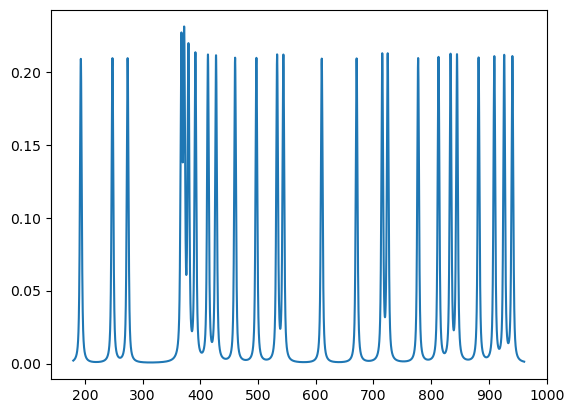

In [101]:
#confirm this correctly sums the voigt profiles
composite = np.sum(profiles, axis=0)
plt.plot(li2co3_wave, composite)

In [102]:
np.max(composite - li2co3_spec)
#this works, dim match

-0.4706562077638463

In [103]:
#now we'll use the scikit least-squares algo to find the intensities that minimize error with these n peaks
#Try https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

#define the residuals function (note algorithm squares for SSE)
def fun_fitspec(l_heights, shifts, y_spec):
    #calculate and sum
    return np.sum(l_heights[:,None] * voigt(shifts, sigma, gamma),axis=0) - y_spec

#weight bounds passed as a 2-tuple of vectors ([lower], [upper]) use np.inf for unbounded
#lower bound for all is non-negative weights
bnd_low = np.zeros(len(li2co3_peak_loc))
#upper bound is 1 (pure). must include small delta to zero to exclude, e.g. 0.0001
bnd_up = 20 * np.max(li2co3_spec) * np.ones(len(li2co3_peak_loc))
h_bounds = (bnd_low, bnd_up)
#Initial guess at line heights is proportional to peak heights
x0 = li2co3_peak_height 

#use the following form to run the LS min for a given input_spec of shape 
line_fit = least_squares(fun_fitspec, x0, args=(li2co3_shifts, li2co3_spec), bounds=h_bounds)

In [104]:
li2co3_fit_hts = line_fit.x.copy()
li2co3_fit_hts

array([5.20540383e+03, 4.29951369e+02, 6.37737653e+01, 9.93604003e+01,
       1.48245802e+02, 2.40809998e+02, 4.34608898e+02, 1.00403012e+03,
       6.46167117e+01, 2.91164583e+03, 3.19517999e+02, 6.12270701e+00,
       1.73558716e+00, 1.66759710e+04, 4.10045818e+04, 6.73515798e+00,
       2.82448255e+00, 6.00877048e+02, 2.69851999e+03, 4.15463815e+01,
       2.46115174e+02, 8.33490102e+00, 3.54907938e+02, 3.25609675e+02,
       2.00327858e+02])

<BarContainer object of 25 artists>

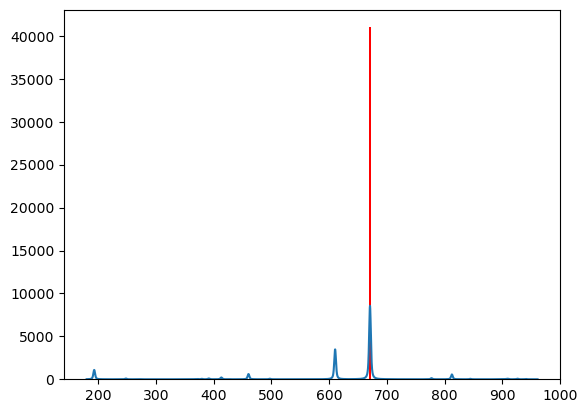

In [105]:
#Now plot the fit heights on top of the input spectrum
plt.plot(li2co3_wave, li2co3_spec)
plt.bar(peak_loc,li2co3_fit_hts,color='red',width=3)

In [106]:
#In end state, we'll use these lines and relative heights to determine ion emissions at specific temps.
#Lab has found better experimental fit allowing for varying plasma temps.
#For given element, ionization states are f(Temp) and see different relative wl emissions based on temp
#With a function to produce lines as function of weighted element tuples of (ion, temp)
#That could be single step fit as min[spec - w(scale)*Sum(emission(ion(i,T(i))))]

In [107]:
#For our simulated spectra we ran at default NIST LIBs temp/condition and rolled up lines by element
lines_file = "nist_libs_hi_res.pickle"
#create element list for this data file
with open(datapath / 'nist_libs' /lines_file, 'rb') as f:
    nist_wave = pickle.load(f)
    atom_lines = pickle.load(f)
avail_elem = [key for key in atom_lines.keys()]
el_index = {} #lookup from el symb to array index of element
ind = 0
for el in avail_elem:
    el_index[el] = ind
    ind += 1
nist_min_wl = nist_wave[0]
nist_wl_inc = nist_wave[1] - nist_wave[0]

In [108]:
# atom lines is a dict so need to put this into an array for weighted multiplication by elemental composition variables
# will have a separate weight(first element) for scaling. Elements bounded [0,1] and will rescale to sum 1 after convergence
el_lines = np.zeros((len(avail_elem),len(nist_wave)))
i = 0
for el in avail_elem:
    el_lines[i] = atom_lines[el]
    i += 1

In [109]:
#confirm wavelength domain aligment
np.all(nist_wave == li2co3_wave)

True

In [110]:
#create a full wavelength format of the fit lines from above based on peak_loc, fit_heights
li2co3_lfit = np.zeros(len(li2co3_wave))
wl_offset = li2co3_wave[0] #subtract from actual wavelength to get index in wave array
wl_inc = li2co3_wave[1] - li2co3_wave[0]
i = 0
for peak in li2co3_peak_loc:
    #we happen to know index aligns since lines assigned from spectra wave index
    peak_ind = np.round((peak - wl_offset) / wl_inc, 0).astype('int')
    li2co3_lfit[peak_ind] = li2co3_fit_hts[i]
    i += 1

In [111]:
#define the residuals function (note algorithm squares for SSE)
def fun_fitlines(fit_wts, el_lines, y_lines):
    #calculate and sum
    return np.sum(fit_wts[:,None] * el_lines, axis=0) - y_lines

#Initial guess at line heights is proportional 1/n
x0 = (1/len(avail_elem)) * np.ones(len(avail_elem))

#weight bounds passed as a 2-tuple of vectors ([lower], [upper]) use np.inf for unbounded
#lower bound for all is non-negative weights
bnd_low = np.zeros(len(x0))
#upper bound is 1 (pure). must include small delta to zero to exclude, e.g. 0.0001
bnd_up = 1e8 * np.ones(len(x0))
h_bounds = (bnd_low, bnd_up)

#run the LS min
comp_fit = least_squares(fun_fitlines, x0, args=(el_lines, li2co3_lfit), bounds=h_bounds)

In [112]:
fit_wts = comp_fit.x.copy()
fit_wts

array([3.54207108e-08, 2.72056300e-08, 3.80577170e-01, 4.78156221e-08,
       4.80853800e-08, 1.69703993e-01, 4.41689424e-09, 9.98572840e-02,
       5.99398152e-08, 7.25194861e-03, 1.43840313e-08, 4.76716636e-08,
       1.17002730e-06, 4.80166254e-08, 4.82719881e-08, 4.76470298e-08,
       4.09284447e-08, 4.03328741e-08, 4.76837535e-08, 4.76642177e-08,
       4.71842257e-08, 3.41577150e-08, 2.05353509e-08, 2.84466516e-08,
       4.72713563e-08, 1.61771229e-08, 4.73990047e-08, 4.63370157e-08,
       4.45477017e-08, 4.76962833e-08, 4.82653003e-08, 4.53901209e-08,
       4.77411375e-08, 4.62570569e-15, 7.44893168e-09, 3.17570814e-08,
       4.76713210e-08, 4.49036833e-08, 4.94406620e-08, 5.41583340e-05,
       4.53862497e-08, 2.43801532e-08, 2.89699211e-08, 1.25769019e-08,
       4.79126779e-08, 4.76856560e-08, 4.43401196e-08, 2.98847183e-08,
       4.85093082e-08, 4.80916305e-08, 5.49002177e-08, 3.36687832e-04,
       4.76853884e-08, 4.72907443e-08, 3.67012410e-08, 2.52641263e-07,
      

In [113]:
el_arr = np.array(avail_elem)

In [114]:
el_arr[fit_wts > 0.01]

array(['Li', 'C', 'O'], dtype='<U2')

In [115]:
raw_wt = np.sum(fit_wts)
raw_wt

0.6577889962716927

In [116]:
fit_wts = fit_wts / raw_wt

In [117]:
#apply threshold
min_wt = 0.01
fit_wts[fit_wts < min_wt] = 0

In [118]:
#rescale last time
fit_wts = fit_wts / np.sum(fit_wts)

In [119]:
#Results
i = 0
for el in avail_elem:
    if fit_wts[i] > 0:
        print(f"{el}: {fit_wts[i]}")
    i += 1

Li: 0.5789210988335941
C: 0.2581479648853626
O: 0.15189951772043422
Ne: 0.011031418560609067


In [120]:
#compare to inputs to spectral simulation
print(fracs_dict)

{'Li': 0.33, 'C': 0.17, 'O': 0.5}


In [121]:
#Build a class for library 

class peaks_fitter():
    #Class variables, access with self.var but do not modify else instance self.var "masks" class var
    lines_file = "nist_libs_hi_res.pickle"
    #lines_file = "nist_elem_libs.pickle"
    #create element list for this data file
    with open(datapath / 'nist_libs' / lines_file, 'rb') as f:
        ref_wave = pickle.load(f)
        atom_lines = pickle.load(f)
    avail_elem = [key for key in atom_lines.keys()]
    el_index = {} #lookup from el symb to array index of element
    ind = 0
    for el in avail_elem:
        el_index[el] = ind
        ind += 1
    #array representation of elemental line intensities
    el_lines = np.zeros((len(avail_elem),len(ref_wave)))
    i = 0
    for el in avail_elem:
        el_lines[i] = atom_lines[el]
        i += 1

    def __init__(self) -> None:
        super().__init__()
        #TODO determine if reference wave/int data passed or global as now

    #define the residuals function for line heights at peaks (note algorithm squares for SSE)
    def fun_fitspec(self, l_heights, shifts, y_spec, sigma, gamma):
        #calculate and sum
        return np.sum(l_heights[:,None] * voigt(shifts, sigma, gamma),axis=0) - y_spec

    #define the residuals function for element weights to fit spectral lines
    def fun_fitlines(self, fit_wts, el_lines, y_lines):
        #calculate and sum
        return np.sum(fit_wts[:,None] * el_lines, axis=0) - y_lines

    def find_peaks(self, libs_wave, libs_intens, n_samp=10, peak_qtile=0.95):
        #resample input spec to supported range/resolution for model
        #assume even spacing monotonic nanometer wavelength grid
        wl_min = self.ref_wave[0]
        wl_inc = self.ref_wave[1] - self.ref_wave[0]
        wl_max = self.ref_wave[-1]
        resamp_spec = np.zeros(len(self.ref_wave))
    
        #Our reference builds from wl_min in increments of wl_inc. Put exp wl on this index
        for i in range(len(libs_wave)):
        
            #ensure exp wl in modeled range
            if libs_wave[i] < wl_min or libs_wave[i] > wl_max:
                continue
            #find index of nearest reference wl. put intensity there
            else:
                wl_ind = np.round((libs_wave[i] - wl_min)/wl_inc, 0).astype('int')
                resamp_spec[wl_ind] += libs_intens[i]

        #with resamp_spec as resampled spectrum aligned with ref_wave, proceed with peak find/fit
        #to smooth peak finding and avoid noise average the point with n_samp pre/post.
        #so we're going to shrink the experimental range by n_samp point on each side of spectra
        #zero out these skipped points in the array of averages (match ref_spec size)

        avg_spec = np.zeros(len(self.ref_wave))
        for i in range(len(resamp_spec)):
            if i < n_samp or i >= (len(resamp_spec) - n_samp):
                continue
            else:
                avg_spec[i] = np.average(resamp_spec[(i-n_samp):(i+n_samp+1)])#numpy slice excludes endpoint
                
        #limit peak finding to > cutoff quantile of peak intensities
        min_peak = np.quantile(resamp_spec, peak_qtile)
        #peak identification based on averages, skip first and last points for indexing
        peaks = np.zeros(len(self.ref_wave)).astype('int')
        for wl_ind in range(len(self.ref_wave)):
            if (wl_ind == 0 or wl_ind == len(self.ref_wave)-1) or resamp_spec[wl_ind] < min_peak:
                continue
            elif (avg_spec[wl_ind] > avg_spec[wl_ind - 1] and avg_spec[wl_ind] > avg_spec[wl_ind + 1]):
                peaks[wl_ind] = 1
            else:
                continue

        #determine the wavelengths to center the profiles on
        peak_loc = np.zeros(np.sum(peaks)) #peaks is full wl array with 1 indicating peak
        peak_height = np.zeros(np.sum(peaks))
        j = 0
        for i in range(len(self.ref_wave)):
            if peaks[i] == 1:
                peak_loc[j] = self.ref_wave[i]
                peak_height[j] = resamp_spec[i] #note: not avg, actual peak val
                j += 1
                
        return self.ref_wave, resamp_spec, peak_loc, peak_height, avg_spec
        
    def find_heights (self, spec, peak_loc, peak_height, sigma=1, gamma=1):
        #L-S fit to find Line heights at peak locations that best fit input spec
        shifts = np.ones((len(peak_loc), len(self.ref_wave)))
        shifts = shifts * self.ref_wave
        shifts = shifts - peak_loc[:,None] #for each of n peaks, array of peak-centered wl offsets
        bnd_low = np.zeros(len(peak_height))
        #Upper bound needs to be bigger than max peak (lines integrated)
        bnd_up = 1e4 * np.max(spec) * np.ones(len(peak_height))
        h_bounds = (bnd_low, bnd_up)
        #Initial guess at line heights is proportional to peak heights
        x0 = peak_height

        #use the following form to run the LS min for a given input_spec of shape 
        line_fit = least_squares(self.fun_fitspec, x0, args=(shifts, spec, sigma, gamma), bounds=h_bounds)
        #TODO check for intensity at max value
        fit_heights = line_fit.x.copy()

        #create a full wavelength format of the fit lines from above based on peak_loc, fit_heights
        y_lines = np.zeros(len(self.ref_wave))
        wl_offset = self.ref_wave[0] #subtract from actual wavelength to get index in wave array
        wl_inc = self.ref_wave[1] -  self.ref_wave[0]
        i = 0
        for peak in peak_loc:
            peak_ind = np.round((peak - wl_offset) / wl_inc, 0).astype('int')
            y_lines[peak_ind] = fit_heights[i]
            i += 1

        return y_lines
                


    def find_el(self, libs_wave, libs_intens, sigma=1, gamma=1, peak_qtile = 0, n_samp=10, min_wt = 0.01):
        
        resamp_wave, resamp_spec, peak_loc, peak_height, avg_spec = self.find_peaks(libs_wave, libs_intens, peak_qtile = peak_qtile, n_samp=n_samp)
        y_lines = self.find_heights(resamp_spec, peak_loc, peak_height, sigma, gamma)
        
        #Initial guess at element weights is proportional 1/n
        x0 = (1/len(self.avail_elem)) * np.ones(len(self.avail_elem))
        #lower bound for all is non-negative weights
        bnd_low = np.zeros(len(x0))
        #upper bound is 1. Note: need a small delta if aim to exclude min=0, max = 1e-4
        bnd_up = np.ones(len(x0))
        h_bounds = (bnd_low, bnd_up)

        #run the LS min
        #return x0, h_bounds, self.el_lines, y_lines #confirmed same inputs as manual run
        el_fit = least_squares(self.fun_fitlines, x0, args=(self.el_lines, y_lines), bounds=h_bounds)
        fit_wts = el_fit.x.copy()
        fit_wts = fit_wts / np.sum(fit_wts)
        fit_wts[fit_wts < min_wt] = 0
        fit_wts = fit_wts / np.sum(fit_wts)
        #create a results dict to return
        results = {}
        for i in range(len(fit_wts)):
            if fit_wts[i] > 0:
                results[avail_elem[i]] = fit_wts[i]
        
        return results                                    

In [122]:
#test peak finding, see if we get same results as non-class code fit_heights, fit_wts
peak_fitter = peaks_fitter()
ref_wave, resamp_spec, cpeak_loc, cpeak_height, avg_spec = peak_fitter.find_peaks(li2co3_wave, li2co3_spec, n_samp=0, peak_qtile=0)
print(np.all([li2co3_peak_loc == cpeak_loc]))
print(np.all([np.abs(li2co3_peak_height - cpeak_height) < 0.01]))
#tab_head = ['peak_loc', 'peak', 'cpeak_loc', 'cpeak']
#fig = go.Figure(data=[go.Table(header=dict(values=tab_head),
#        cells=dict(values=[li2co3_peak_loc, li2co3_peak_height, cpeak_loc, cpeak_height],align='right'))])
#fig.update_layout(width=800, height=800)                   
#fig.show()

True
True


In [123]:
#next compare line height finding
cy_lines = peak_fitter.find_heights (resamp_spec, cpeak_loc, cpeak_height, sigma=1, gamma=1)

In [124]:
np.all([(li2co3_lfit - cy_lines) < 1e-3])

True

In [125]:
peak_fitter = peaks_fitter()
results = peak_fitter.find_el(li2co3_wave, li2co3_spec, peak_qtile=0, n_samp=0, min_wt=0.01)
results #these match the manually developed results, so class looks good functionally

{'Li': 0.5789213917782632,
 'C': 0.25814809548968265,
 'O': 0.15189957397175083,
 'Ne': 0.011030938760303399}

In [126]:
#now try with experimental spectrum
filepath = "experimental/LIBS_Li2CO3.csv"
#filepath = "experimental/TLC_10-13-22/95-Test #95 17 29, Oct 13 2022.10.13.17.29.csv"
libs_spec = np.genfromtxt(datapath / filepath, delimiter=',', skip_header=1)
#will need to resample to our model specs for wavelength resolution
libs_wave = libs_spec[:,0]
libs_intens = libs_spec[:,1]
libs_intens[libs_intens < 0] = 0


<function matplotlib.pyplot.show(close=None, block=None)>

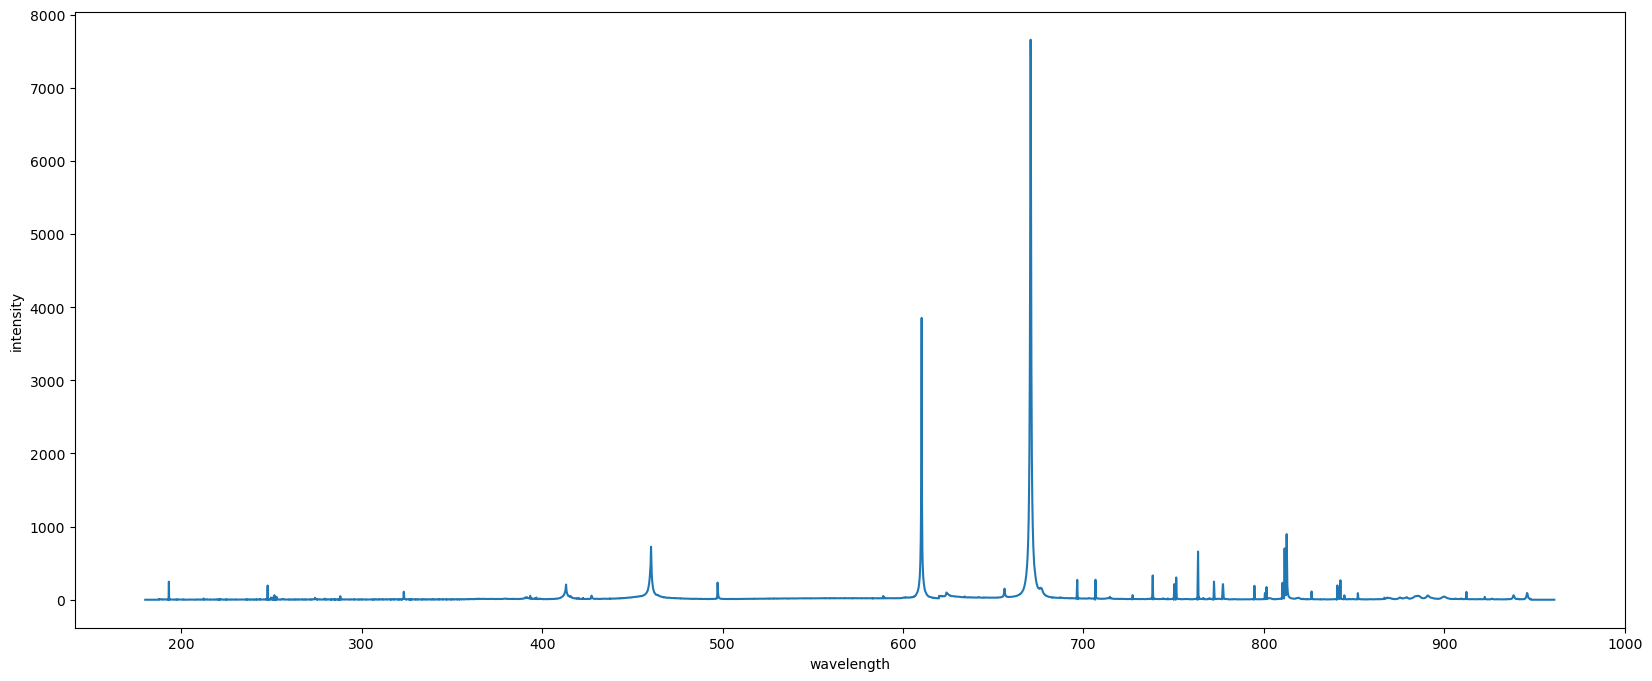

In [127]:
#Review experimental Li2CO3 spectrum plot
plt.figure(figsize=(20,8))
plt.plot(libs_wave, libs_intens)
plt.xlabel('wavelength')
plt.ylabel('intensity')
plt.show # Looks properly scaled

In [128]:
peak_fitter  = peaks_fitter()
results = peak_fitter.find_el(libs_wave, libs_intens, peak_qtile = 0.85, min_wt = 0.01)
results #H only highlights flaw. Low int H has >> wt so normalizing to 1 pushes others below thresh
#TODO filter/scale on contributed intensity (wt[el] * sum(lines[el]))

{'H': 1.0}

<BarContainer object of 80 artists>

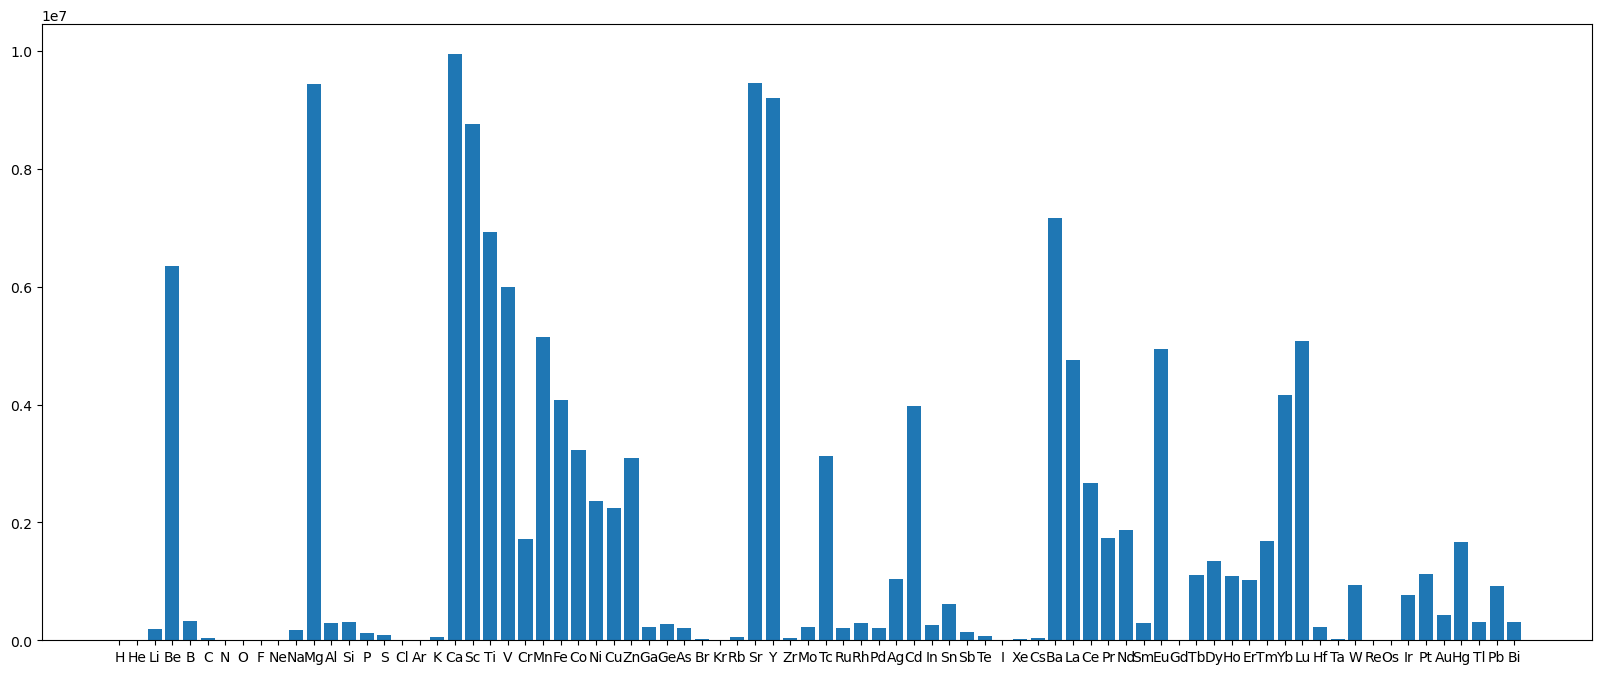

In [129]:
#calc total line intensity for each element
el_int = np.sum(el_lines, axis=1)
plt.figure(figsize=(20,8))
plt.bar(avail_elem,el_int)

Text(0.5, 1.0, 'Li2CO3 (Li-orange, C-blue, O-red)')

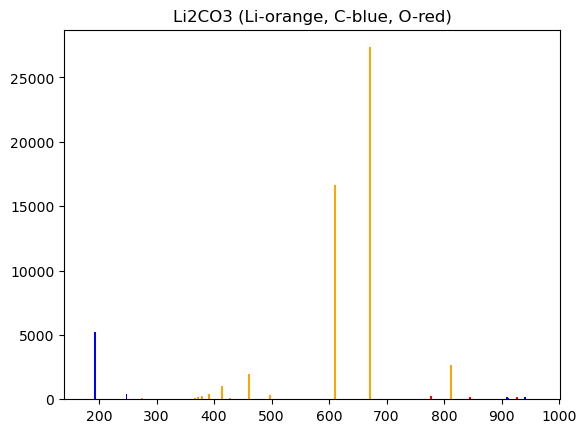

In [130]:
#There may be a fundamental scale issue. Look at simulated spec and corresponding lines scaled to same total intensity
#Look at relative line intensity for simulated Li2CO3
plt.bar(nist_wave, 0.33*atom_lines['Li'], width=3,color='orange')
plt.bar(nist_wave, 0.17*atom_lines['C'],width=3,color='blue')
plt.bar(nist_wave, 0.5*atom_lines['O'],width=3,color='red')
plt.title("Li2CO3 (Li-orange, C-blue, O-red)")

0.0


(0.0, 1000000.0)

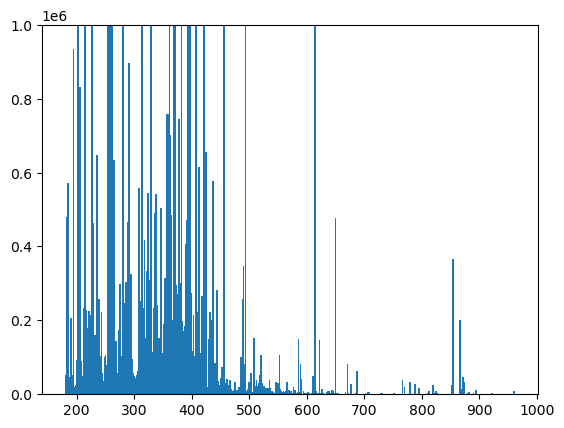

In [131]:
#Seems we should use the structure of what's available in terms of line sets to address noise
#All we can really tell from spectra is relative intensity/composition (?)
#Though it would be incredibly useful to be able to tell absolute composition from clear peaks (so we know how much more we seek)
#looking across elements, are their wavelengths we just don't expect to see line emissions at?
all_lines = np.sum(el_lines, axis=0)
print(np.min(all_lines))
plt.bar(nist_wave,all_lines,width=3)
plt.ylim(0,1e6)

#plt.yscale('log')

0.0898717


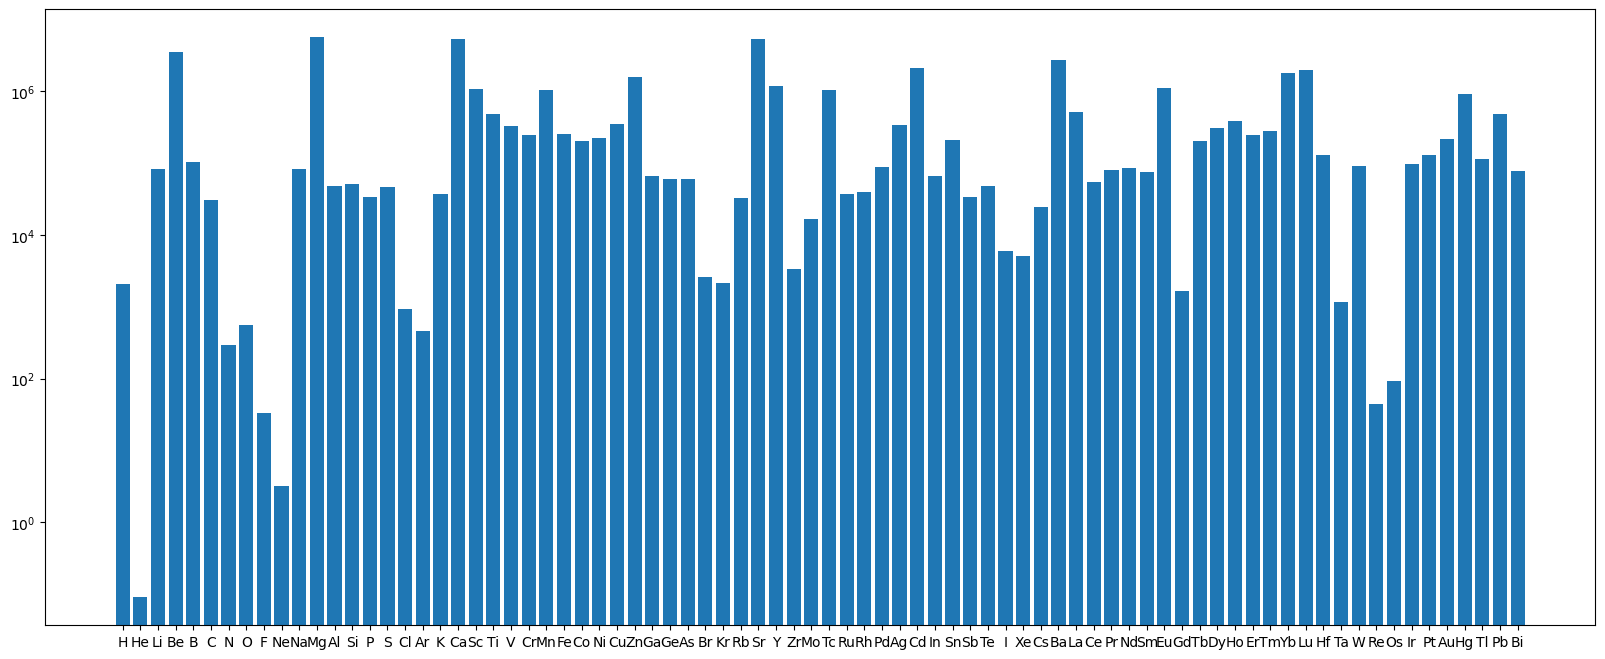

In [132]:
#Max line emission value by element
el_max = np.max(el_lines,axis=1)
print(np.min(el_max))
plt.figure(figsize=(20,8))
plt.bar(avail_elem,el_max)
plt.yscale('log')
#There is useful structure here. He isn't going to read on LIBS but Ne might and max line is ~4 orders < Li


In [133]:
#to find the "n greatest" efficiently we use argpartition
ex_arr = np.array([6,3,7,5,1,9])
#find smallest 2
print(np.argpartition(ex_arr,2)[:2]) #indices 4,1 are the smallest values (1 & 3)
#use negative indexing (from end of array) for max
print(np.argpartition(ex_arr,-2)[-2:]) #

[4 1]
[2 5]


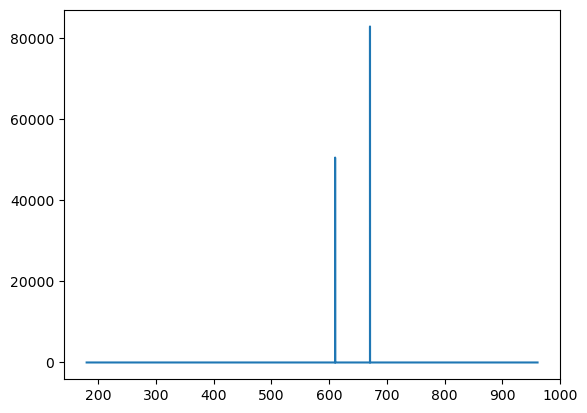

In [134]:
#Maybe better to do this on basis of numerical comparison
#Take two biggest peaks from focus element and compare to intensity from rest of elements
el_isolate = 'Li'
iso_el_ind = el_index[el_isolate]
el_others = all_lines - el_lines[iso_el_ind]
max_2ind = np.argpartition(el_lines[iso_el_ind],-2)[-2:]
el_iso_max2 = np.zeros(len(nist_wave))
el_iso_max2[max_2ind] = el_lines[iso_el_ind][max_2ind]
plt.plot(nist_wave,el_iso_max2)

In [135]:
line_interfere = el_others[max_2ind] / el_iso_max2[max_2ind]
line_interfere #none for top two peak locations for Li

array([0., 0.])

In [136]:
np.get_printoptions()['precision']

8

In [137]:
a = np.array([[1.23, 4.56, 6.75],[2.34, 4.55, 6.99]])
strings = ['{:.1f}'.format(x) for x in a[:,0]]
strings

['1.2', '2.3']

In [138]:
test = avail_elem.copy()
id(test) == id(avail_elem)

False

In [139]:
cell_text = [['text' for i in range(5)] for i in range(3)]
cell_text

[['text', 'text', 'text', 'text', 'text'],
 ['text', 'text', 'text', 'text', 'text'],
 ['text', 'text', 'text', 'text', 'text']]

In [140]:
[['test']]*3

[['test'], ['test'], ['test']]

In [141]:
#argsort
b = np.array([3, 5, 0])
sort_ind = np.argsort(b)
b = b[sort_ind]
b



array([0, 3, 5])

In [142]:
#spread an index to sum interference
test_arr = np.array([x for x in range(10)])
print(test_arr)
test_ind = [3,5]
test_arr[test_ind]
spread = 2
new_arr = np.zeros(len(test_ind))
i=0
for center in test_ind:
    new_arr[i] = np.sum(test_arr[center-spread:center+spread+1])
    i+=1
print(new_arr)
[np.sum(test_arr[j-spread:j+spread+1]) for j in test_ind]

[0 1 2 3 4 5 6 7 8 9]
[15. 25.]


[15, 25]

In [143]:
#note on reversing sort order with[::-1]
test_arr = [2,1,4,3,5]
print(np.argsort(test_arr))
print(np.argsort(test_arr)[::-1])

[1 0 3 2 4]
[4 2 3 0 1]


In [144]:
#Make a table of this data with top 3 wavelengths for every element
#plotly takes data in column form as lists, plan to format text for cols
n_top = 3
infc_thresh = 0.25
infc_band = 0 #best signals do not have close neighbors. Units = wl increments
all_lines = np.sum(el_lines, axis=0)
el_waves = np.zeros((len(avail_elem), 3))
el_inten = np.zeros((len(avail_elem), 3))
el_infc = np.zeros((len(avail_elem), 3))
cell_col = [['lightblue' for i in range(len(avail_elem))] for i in range(3*n_top + 1)] #override to highlight
warn_color = 'yellow'
i = 0 #note el_lines indexing same as avail_elem by construction
for el in avail_elem:
    #find the n_top max intensity wavelengths
    top_ind = np.argpartition(el_lines[i], -n_top)[-n_top:]
    el_waves[i] = nist_wave[top_ind]
    el_inten[i] = el_lines[i][top_ind]
    #get additive spectrum of all other lines without this element
    el_others = all_lines - el_lines[i]
    el_infc[i] = [np.sum(el_others[i-infc_band:i+infc_band+1]) for i in top_ind] / el_lines[i][top_ind]

    #sort by non-infc intensity to elevate lowest interference lines
    sort_ind = np.argsort(el_inten[i] * (1 - el_infc[i]))[::-1] #descending sort now
    el_waves[i] = el_waves[i][sort_ind]
    el_inten[i] = el_inten[i][sort_ind]
    el_infc[i] = el_infc[i][sort_ind]
    #highlight the row if second interference figure about threshold
    if el_infc[i][1] > infc_thresh:
        for col in cell_col:
            col[i] = warn_color

    i += 1

tab_head = ['Elem','WL1','WL1 Inten', 'WL1 Infc', 'WL2','WL2 Inten','WL2 Infc', 'WL3','WL3 Inten','WL3 Infc']
data_cols = [avail_elem.copy()]
for i in range(n_top):
    data_cols.append(['{:.3f}'.format(x) for x in el_waves[:,i]])
    data_cols.append(['{:,.2f}'.format(x) for x in el_inten[:,i]])
    data_cols.append(['{:.4f}'.format(x) for x in el_infc[:,i]])

fig = go.Figure(data=[go.Table(
    columnwidth = [40,75,100,100,75,100,100,75,100,100],
    header=dict(values=tab_head),
    cells=dict(values=data_cols,
                align='right',
                fill_color = cell_col))])

fig.update_layout(width=1200, height=1900)
                    
fig.show()

In [145]:
#confirm all wl are unique
el_ref_wl = el_waves[:,0:2]
for i in range(len(el_ref_wl)):
    if el_ref_wl[i,0] in el_ref_wl[:,1]:
        print(avail_elem[i])
    i += 1

In [146]:
# Look at a totally different fit type using only weights/loss on these primary line points
# Keep all elements at this point, choose which to test
#flatten the data
el_ref_inten = np.concatenate((el_inten[:,0], el_inten[:,1]))
el_ref_wl = np.concatenate((el_waves[:,0], el_waves[:,1]))
# Could penalize inverse to intensity, otherwise large weights on weak elements sail through
#el_loss_mul = 1 / np.sum(el_inten[:,0:2], axis=1)
#el_loss_mul = np.concatenate((el_loss_mul, el_loss_mul))
#el_loss_mul = np.ones(len(el_ref_inten))
#we extract the spectral intensities from unknown spectrum at these wl
#get the wave indices needed to do this, assume has been put on nist_wave basis at this point
el_ref_ind = -np.ones(len(el_ref_wl), dtype='int') #initialize as invalid index assign in loop
i = 0
for wl in el_ref_wl:
    el_ref_ind[i] = np.round((wl - nist_min_wl) / nist_wl_inc, 0).astype('int')
    i += 1

y_lines = li2co3_lines[el_ref_ind] #TODO how to handle non-unique ref wl if we allow that

def line_resid(fit_wts, el_ref_inten, y_lines):
    return np.concatenate((fit_wts, fit_wts)) * el_ref_inten - y_lines

In [147]:
 #Initial guess at element weights is proportional 1/n
#x0 = (1/len(avail_elem)) * np.ones(len(avail_elem))
x0 = np.zeros(len(avail_elem))
#lower bound for all is non-negative weights
bnd_low = np.zeros(len(x0))
bnd_up = 1e8 * np.ones(len(x0))
h_bounds = (bnd_low, bnd_up)

#run the LS min
el_fit = least_squares(line_resid, x0, args=(el_ref_inten, y_lines), bounds=h_bounds)
fit_wts = el_fit.x.copy()

In [148]:
#check weights found
fit_wts = fit_wts / np.sum(fit_wts)
fit_wts[fit_wts < 0.01] = 0
fit_wts = fit_wts / np.sum(fit_wts)
i=0
for el in avail_elem:
    if fit_wts[i] > 0:
        print(f'{avail_elem[i]}: {fit_wts[i]:.3f}')
    i += 1

Li: 0.330
C: 0.170
O: 0.500


In [149]:
#check for line alignment between y_lines and elemental lines and fit lines (good)
fit_inten = np.concatenate((fit_wts, fit_wts)) * el_ref_inten
tab_head = ['Elem','WL1','WL1 Inten', 'WL1 Infc', 'WL2','WL2 Inten','WL2 Infc', 'Samp_Int WL1', 'Samp_Int WL2', 'Fit_Int WL1', 'Fit_Int WL2']
data_cols = [avail_elem.copy()]
for i in range(2):
    data_cols.append(['{:.3f}'.format(x) for x in el_waves[:,i]])
    data_cols.append(['{:,.2f}'.format(x) for x in el_inten[:,i]])
    data_cols.append(['{:.4f}'.format(x) for x in el_infc[:,i]])

#add the y_lines sample intensity to check alignment
data_cols.append(['{:,.2f}'.format(x) for x in y_lines[0:len(avail_elem)]])
data_cols.append(['{:,.2f}'.format(x) for x in y_lines[len(avail_elem):]])
data_cols.append(['{:,.2f}'.format(x) for x in fit_inten[0:len(avail_elem)]])
data_cols.append(['{:,.2f}'.format(x) for x in fit_inten[len(avail_elem):]])


fig = go.Figure(data=[go.Table(
    #columnwidth = [40,75,100,100,75,100,100,75,100,100],
    header=dict(values=tab_head),
    cells=dict(values=data_cols,
                align='right',
                #fill_color = cell_col
                ))])

fig.update_layout(width=1200, height=1900)
                    
fig.show()

In [150]:
#Now check this with experimental libs spec
ref_wave, resamp_spec, peak_loc, peak_height, avg_spec = peak_fitter.find_peaks(libs_wave, libs_intens)
spec_lines = peak_fitter.find_heights(resamp_spec, peak_loc, peak_height)
y_lines = spec_lines[el_ref_ind]
#run the LS min
el_fit = least_squares(line_resid, x0, args=(el_ref_inten, y_lines), bounds=h_bounds)
fit_wts = el_fit.x.copy()

In [151]:
#check weights found
fit_wts = fit_wts / np.sum(fit_wts)
fit_wts[fit_wts < 0.01] = 0
fit_wts = fit_wts / np.sum(fit_wts)
i=0
for el in avail_elem:
    if fit_wts[i] > 0:
        print(f'{avail_elem[i]}: {fit_wts[i]:.3f}')
    i += 1

H: 1.000


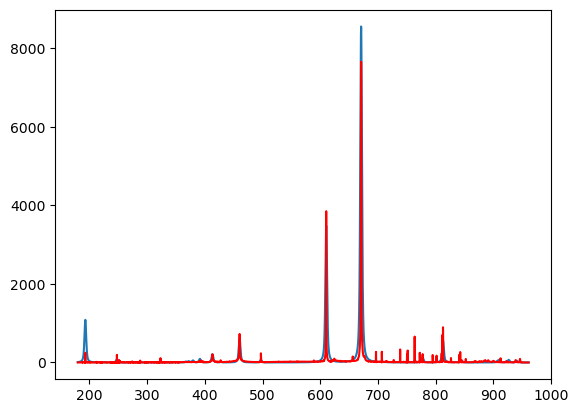

In [152]:
#experimental vs synthetic li2co3
plt.plot(li2co3_wave, li2co3_spec)
plt.plot(libs_wave, libs_intens, color='red')

<BarContainer object of 23431 artists>

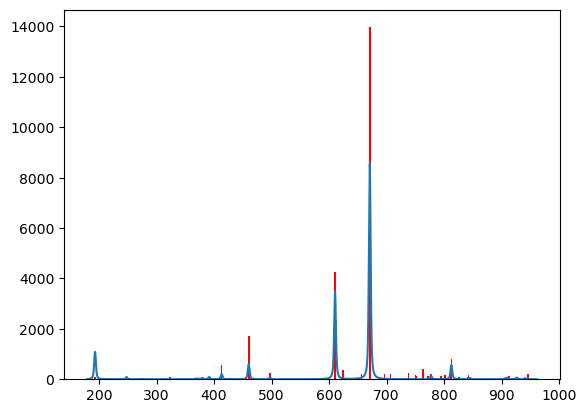

In [153]:
# let's look at the experimental lines vs. expected for li2co3
plt.plot(li2co3_wave, li2co3_spec)
plt.bar(ref_wave, spec_lines, width=3,color='red')

In [154]:
#suspect imperfect alignment of found line loc and reference line loc
#technique may be needed to shift/widen the experimental lines compared to each reference line?

#fit_inten = np.concatenate((fit_wts, fit_wts)) * el_ref_inten
tab_head = ['Elem','WL1','WL1 Inten', 'WL1 Infc', 'WL2','WL2 Inten','WL2 Infc', 'Samp_Int WL1', 'Samp_Int WL2']#, 'Fit_Int WL1', 'Fit_Int WL2']
data_cols = [avail_elem.copy()]
for i in range(2):
    data_cols.append(['{:.3f}'.format(x) for x in el_waves[:,i]])
    data_cols.append(['{:,.2f}'.format(x) for x in el_inten[:,i]])
    data_cols.append(['{:.4f}'.format(x) for x in el_infc[:,i]])

#add the y_lines sample intensity to check alignment
data_cols.append(['{:,.2f}'.format(x) for x in y_lines[0:len(avail_elem)]])
data_cols.append(['{:,.2f}'.format(x) for x in y_lines[len(avail_elem):]])
#data_cols.append(['{:,.2f}'.format(x) for x in fit_inten[0:len(avail_elem)]])
#data_cols.append(['{:,.2f}'.format(x) for x in fit_inten[len(avail_elem):]])


fig = go.Figure(data=[go.Table(
    #columnwidth = [40,75,100,100,75,100,100,75,100,100],
    header=dict(values=tab_head),
    cells=dict(values=data_cols,
                align='right',
                #fill_color = cell_col
                ))])

fig.update_layout(width=1200, height=1900)
                    
fig.show()


In [155]:
#find the lithium line loc for experimental
ref_wave[np.argmax(spec_lines)]
#off by a single 0.03 increment! 670.767 reference

670.7333333333054

In [156]:
#instead represent y_lines as a spread around the reference wavelengths equal to 0.067 nm (increases interference potential)
line_spr = 5
y_lines = np.zeros(len(el_ref_ind))
for i in range(-line_spr,line_spr+1,1):
    y_lines += spec_lines[el_ref_ind + i]

tab_head = ['Elem','WL1','WL1 Inten', 'WL1 Infc', 'WL2','WL2 Inten','WL2 Infc', 'Samp_Int WL1', 'Samp_Int WL2']#, 'Fit_Int WL1', 'Fit_Int WL2']
data_cols = [avail_elem.copy()]
for i in range(2):
    data_cols.append(['{:.3f}'.format(x) for x in el_waves[:,i]])
    data_cols.append(['{:,.2f}'.format(x) for x in el_inten[:,i]])
    data_cols.append(['{:.4f}'.format(x) for x in el_infc[:,i]])

#add the y_lines sample intensity to check alignment
data_cols.append(['{:,.2f}'.format(x) for x in y_lines[0:len(avail_elem)]])
data_cols.append(['{:,.2f}'.format(x) for x in y_lines[len(avail_elem):]])
#data_cols.append(['{:,.2f}'.format(x) for x in fit_inten[0:len(avail_elem)]])
#data_cols.append(['{:,.2f}'.format(x) for x in fit_inten[len(avail_elem):]])


fig = go.Figure(data=[go.Table(
    #columnwidth = [40,75,100,100,75,100,100,75,100,100],
    header=dict(values=tab_head),
    cells=dict(values=data_cols,
                align='right',
                #fill_color = cell_col
                ))])

fig.update_layout(width=1200, height=1900)
                    
fig.show()

In [157]:
#try the fitting with this widened y_lines
#run the LS min
el_fit = least_squares(line_resid, x0, args=(el_ref_inten, y_lines), bounds=h_bounds)
fit_wts = el_fit.x.copy()

In [158]:
#check weights found
fit_wts = fit_wts / np.sum(fit_wts)
fit_wts[fit_wts < 0.01] = 0
fit_wts = fit_wts / np.sum(fit_wts)
i=0
for el in avail_elem:
    if fit_wts[i] > 0:
        print(f'{avail_elem[i]}: {fit_wts[i]:.3f}')
    i += 1
#Seems feasible and consistent with carbon peaks missing/reduced in spectrum vs. expected

H: 0.051
Li: 0.082
O: 0.240
Ar: 0.626


In [159]:
wave, spec_dict, lines_dict = spec_maker.make_spectra({'C':1}, comp_only=True)
carb_spec = spec_dict['comp']
carb_lines = lines_dict['comp']

<BarContainer object of 23431 artists>

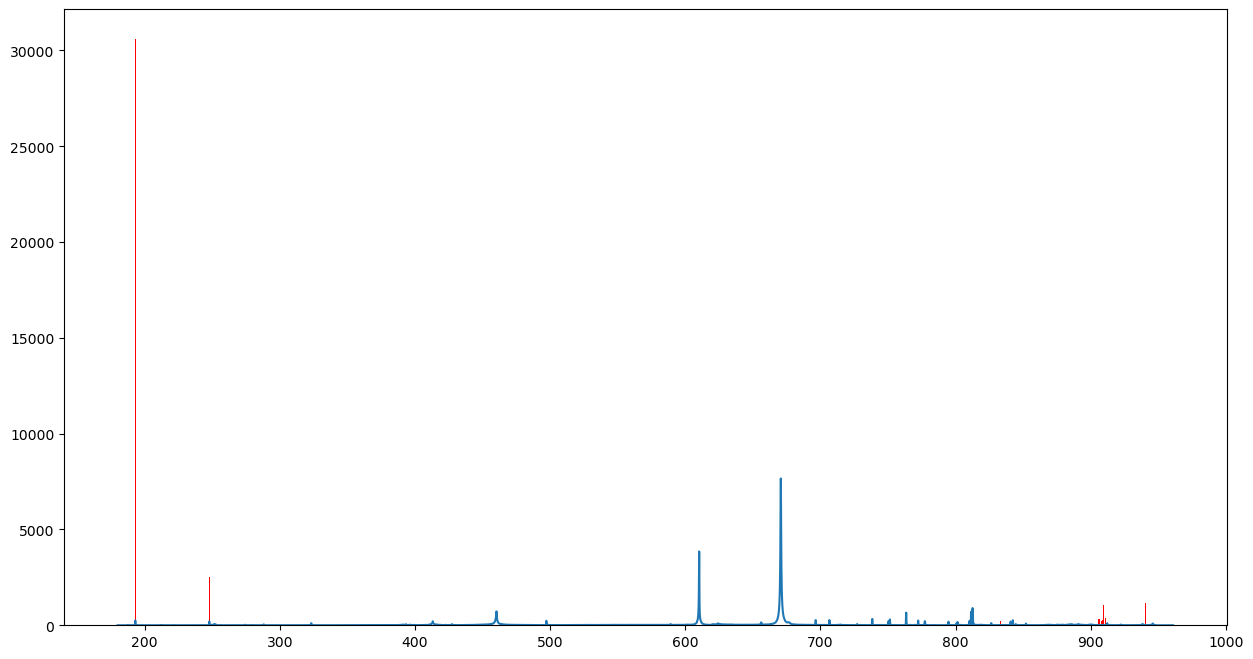

In [160]:
plt.figure(figsize=(15,8))
plt.plot(libs_wave, libs_intens)
plt.bar(wave, carb_lines, width=1, color='red')


In [161]:
#work on a packaging for this approach with persisted key lines data and a class
#pickle save the reference set
#Persist data for use in spectrum generation and other libraries
#with open(datapath / 'nist_libs' / 'el_ref_lines.pickle', 'wb') as f:
#    pickle.dump(el_ref_ind, f)
#    pickle.dump(el_ref_wl, f)
#    pickle.dump(el_ref_inten, f)

#import pickle
#with open(datapath / 'nist_libs' / 'el_ref_lines.pickle', 'rb') as f:
#    el_ref_ind = pickle.load(f)
#    el_ref_wl = pickle.load(f)
#    el_ref_inten = pickle.load(f)


In [162]:
test = np.array([1,2,3,4,5])
corr = np.zeros(len(test))
corr[test < 4] += 1
corr

array([1., 1., 1., 0., 0.])

In [164]:
#re-usable class to run the fit
class atomic_fitter():
    #Bring in standard nist dataset first
    #Class variables, access with self.var but do not modify else instance self.var "masks" class var
    lines_file = "nist_libs_hi_res.pickle"
    #create element list for this data file
    with open(datapath / 'nist_libs' / lines_file, 'rb') as f:
        ref_wave = pickle.load(f)
        atom_lines = pickle.load(f)
    avail_elem = [key for key in atom_lines.keys()]
    ind_max = len(ref_wave) - 1
    el_index = {} #lookup from el symb to array index of element
    ind = 0
    for el in avail_elem:
        el_index[el] = ind
        ind += 1
    #array representation of elemental line intensities
    el_lines = np.zeros((len(avail_elem),len(ref_wave)))
    i = 0
    for el in avail_elem:
        el_lines[i] = atom_lines[el]
        i += 1
    #these are the selected reference lines by element
    
    with open(datapath / 'nist_libs' / 'el_ref_lines.pickle', 'rb') as f:
        el_ref_ind = pickle.load(f)
        el_ref_wl = pickle.load(f)
        el_ref_inten = pickle.load(f)

    def __init__(self) -> None:
        super().__init__()

    def find_peaks(self, libs_wave, libs_intens, peak_samp=10, peak_qtile=0.95):
        #resample input spec to supported range/resolution for model
        #assume even spacing monotonic nanometer wavelength grid
        wl_min = self.ref_wave[0]
        wl_inc = self.ref_wave[1] - self.ref_wave[0]
        wl_max = self.ref_wave[-1]
        resamp_spec = np.zeros(len(self.ref_wave))
    
        #Our reference builds from wl_min in increments of wl_inc. Put exp wl on this index
        for i in range(len(libs_wave)):
        
            #ensure exp wl in modeled range
            if libs_wave[i] < wl_min or libs_wave[i] > wl_max:
                continue
            #find index of nearest reference wl. put intensity there
            else:
                wl_ind = np.round((libs_wave[i] - wl_min)/wl_inc, 0).astype('int')
                resamp_spec[wl_ind] += libs_intens[i]

        #with resamp_spec as resampled spectrum aligned with ref_wave, proceed with peak find/fit
        #to smooth peak finding and avoid noise average the point with peak_samp pre/post.
        #so we're going to shrink the experimental range by peak_samp point on each side of spectra
        #zero out these skipped points in the array of averages (match ref_spec size)

        avg_spec = np.zeros(len(self.ref_wave))
        for i in range(len(resamp_spec)):
            if i < peak_samp or i >= (len(resamp_spec) - peak_samp):
                continue
            else:
                avg_spec[i] = np.average(resamp_spec[(i-peak_samp):(i+peak_samp+1)])#numpy slice excludes endpoint
                
        #limit peak finding to > cutoff quantile of peak intensities
        min_peak = np.quantile(resamp_spec, peak_qtile)
        #peak identification based on averages, skip first and last points for indexing
        peaks = np.zeros(len(self.ref_wave)).astype('int')
        for wl_ind in range(len(self.ref_wave)):
            if (wl_ind == 0 or wl_ind == len(self.ref_wave)-1) or resamp_spec[wl_ind] < min_peak:
                continue
            elif (avg_spec[wl_ind] > avg_spec[wl_ind - 1] and avg_spec[wl_ind] > avg_spec[wl_ind + 1]):
                peaks[wl_ind] = 1
            else:
                continue

        #determine the wavelengths to center the profiles on
        peak_loc = np.zeros(np.sum(peaks)) #peaks is full wl array with 1 indicating peak
        peak_height = np.zeros(np.sum(peaks))
        j = 0
        for i in range(len(self.ref_wave)):
            if peaks[i] == 1:
                peak_loc[j] = self.ref_wave[i]
                peak_height[j] = resamp_spec[i] #note: not avg, actual peak val
                j += 1
                
        return self.ref_wave, resamp_spec, peak_loc, peak_height, avg_spec
    
    #define the residuals function for line heights at peaks (note algorithm squares for SSE)
    def _fun_fitspec(self, l_heights, shifts, y_spec, sigma, gamma):
        #calculate and sum
        return np.sum(l_heights[:,None] * voigt(shifts, sigma, gamma),axis=0) - y_spec
    #private because now relying on alignment with self.ref_wave
    def _find_heights (self, spec, peak_loc, peak_height, sigma=1, gamma=1):
        #L-S fit to find Line heights at peak locations that best fit input spec
        shifts = np.ones((len(peak_loc), len(self.ref_wave)))
        shifts = shifts * self.ref_wave
        shifts = shifts - peak_loc[:,None] #for each of n peaks, array of peak-centered wl offsets
        bnd_low = np.zeros(len(peak_height))
        #Upper bound needs to be bigger than max peak (lines integrated)
        bnd_up = 1e4 * np.max(spec) * np.ones(len(peak_height))
        h_bounds = (bnd_low, bnd_up)
        #Initial guess at line heights is proportional to peak heights
        x0 = peak_height

        #use the following form to run the LS min for a given input_spec of shape 
        line_fit = least_squares(self._fun_fitspec, x0, args=(shifts, spec, sigma, gamma), bounds=h_bounds)
        #TODO check for intensity at max value
        fit_heights = line_fit.x.copy()

        #create a full wavelength format of the fit lines from above based on peak_loc, fit_heights
        y_lines = np.zeros(len(self.ref_wave))
        wl_offset = self.ref_wave[0] #subtract from actual wavelength to get index in wave array
        wl_inc = self.ref_wave[1] -  self.ref_wave[0]
        i = 0
        for peak in peak_loc:
            peak_ind = np.round((peak - wl_offset) / wl_inc, 0).astype('int')
            y_lines[peak_ind] = fit_heights[i]
            i += 1

        return y_lines


    #define the residuals function for weighted lines
    def _line_resid(self, fit_wts, y_lines, extra_var):
        return np.concatenate((fit_wts, fit_wts)) * self.el_ref_inten - y_lines
    
    #TODO add parameter to set element bounds
    #TODO add spec resampling step
    #private due to required prep of spec_lines
    def _fit_elem(self, spec_lines, line_spr = 5, wt_tol = 0.01):
        y_lines = np.zeros(len(self.el_ref_ind))
        y_lines_corr = np.zeros(len(self.el_ref_ind))
        for i in range(-line_spr, line_spr + 1, 1):
            #ensure spread doesn't fall outside valid wl bounds
            adj_ind = self.el_ref_ind + i
            #we corrupt the end points but keep vector efficiency and fix after
            y_lines_corr[adj_ind < 0] += spec_lines[0] #we'll back this out
            adj_ind[adj_ind < 0] = 0 #valid start of array index
            y_lines_corr[adj_ind > self.ind_max] += spec_lines[self.ind_max] #we'll back this out
            adj_ind[adj_ind > self.ind_max] = self.ind_max
            y_lines += spec_lines[adj_ind]
            y_lines -= y_lines_corr

        x0 = (1 / len(self.avail_elem)) * np.ones(len(self.avail_elem))
        #lower bound for all is non-negative weights
        bnd_low = np.zeros(len(x0))
        bnd_up = 1e8 * np.ones(len(x0)) #input spectra scaling is unknown
        h_bounds = (bnd_low, bnd_up)
        el_fit = least_squares(self._line_resid, x0, args=(y_lines, 0), bounds=h_bounds)
        fit_wts = el_fit.x.copy()
        fit_wts = fit_wts / np.sum(fit_wts)
        fit_wts[fit_wts < wt_tol] = 0
        fit_wts = fit_wts / np.sum(fit_wts)
        i = 0
        results_dict = {}
        for el in self.avail_elem:
            if fit_wts[i] > 0:
                results_dict[self.avail_elem[i]] = fit_wts[i]
            i += 1  
        return results_dict
    
    def libs_decomp(self, libs_wave, libs_intens, peak_samp=10, peak_qtile=0.95, sigma=1, gamma=1, line_spr=5, wt_tol=0.01):
        ref_wave, resamp_spec, peak_loc, peak_height, avg_spec = self.find_peaks(libs_wave, libs_intens, peak_samp=peak_samp, peak_qtile=peak_qtile)
        libs_lines = self._find_heights(resamp_spec, peak_loc, peak_height, sigma=sigma, gamma=gamma)
        results = self._fit_elem(libs_lines, line_spr=line_spr, wt_tol=wt_tol)
        return results

In [165]:
#check for same results from class as above code
atom_fitter = atomic_fitter()
comp_dict = atom_fitter.libs_decomp(libs_wave, libs_intens)
for k,v in comp_dict.items():
    print(f'{k}: {v}')

H: 0.051482752983308316
Li: 0.08227894839516144
O: 0.24046248479324342
Ar: 0.6257758138282868


In [168]:
#try another experimental spec from Tonopah
#now try with experimental spectrum
#filepath = "experimental/TLC_10-13-22/45-Test #45 16 22, Oct 13 2022.10.13.16.22.csv"
filepath = "experimental/TLC_10-13-22/95-Test #95 17 29, Oct 13 2022.10.13.17.29.csv"
libs_spec = np.genfromtxt(datapath / filepath, delimiter=',', skip_header=1)
#will need to resample to our model specs for wavelength resolution
libs_wave = libs_spec[:,0]
libs_intens = libs_spec[:,1]
libs_intens[libs_intens < 0] = 0
comp_dict = atom_fitter.libs_decomp(libs_wave, libs_intens, line_spr=1)
for k,v in comp_dict.items():
    print(f'{k}: {v}')

H: 0.15418869889786935
Li: 0.021362221730142836
Si: 0.012362547852743903
Ar: 0.4395930565942447
Gd: 0.37249347492499935
